In [1]:
# Import module
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
import optuna
import plotly.express as px
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from tqdm.auto import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split, Dataset, SubsetRandomSampler, TensorDataset
from torchinfo import summary


In [2]:
# Check if GPU is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device}')


Using cuda


In [3]:
# Define the model architecture as a sequence of linear layers, ReLU activations, and batch normalization
class Model(nn.Module):
    def __init__(self, input_dim, num_hidden_1, num_hidden_2, num_hidden_3, num_hidden_4, num_hidden_5, output_dim):
        super().__init__()
        self.model = nn.Sequential(nn.Linear(input_dim, num_hidden_1),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_1),
                                   nn.Linear(num_hidden_1, num_hidden_2),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_2),
                                   nn.Linear(num_hidden_2, num_hidden_3),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_3),
                                   nn.Linear(num_hidden_3, num_hidden_4),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_4),
                                   nn.Linear(num_hidden_4, num_hidden_5),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_5),
                                   nn.Linear(num_hidden_5, num_hidden_4),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_4),
                                   nn.Linear(num_hidden_4, num_hidden_3),
                                   nn.ReLU(),
                                   nn.BatchNorm1d(num_hidden_3),
                                   nn.Linear(num_hidden_3, num_hidden_2),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_hidden_2),
                                   nn.Linear(num_hidden_2, num_hidden_1),
                                   nn.LeakyReLU(),
                                   nn.BatchNorm1d(num_hidden_1),
                                   nn.Linear(num_hidden_1, output_dim)
                                   )

    def forward(self, x):
        return self.model(x)


In [4]:
def train_epoch(model, dataloader, loss_fn, optimizer, device) -> float:
    num_batches = len(dataloader)  # Number of batches per epoch
    train_loss = 0.0
    model.train()  # Set model to training mode
    for batch, (x, y) in enumerate(dataloader):
        x, y = x.to(device), y.to(device)
        output = model(x)  # Forward propagation
        loss = loss_fn(output, y)  # Calculate loss
        train_loss += loss.item()  # Accumulate loss
        optimizer.zero_grad()  # Zero gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights
    return train_loss/num_batches  # Return average loss


In [5]:
def valid_epoch(model, dataloader, loss_fn, device) -> float:
    num_batches = len(dataloader)  # Number of batches per epoch
    valid_loss = 0.0
    model.eval()  # Set model to evaluation mode
    with torch.inference_mode(mode=True):
        for batch, (x, y) in enumerate(dataloader):
            x, y = x.to(device), y.to(device)
            output = model(x)  # Get model prediction
            loss = loss_fn(output, y)  # Calculate loss
            valid_loss += loss.item()  # Accumulate loss
    return valid_loss/num_batches  # Return average loss


In [6]:
def train(model, train_loader, valid_loader, loss_fn, optimizer, epochs, device):
    # Initializes a defaultdict to store the training and validation losses at each epoch
    result = defaultdict(list)
    # Moved the model to the specified device
    model.to(device)
    # Iterates through each epoch
    for epoch in tqdm(range(1, epochs + 1)):
        # Train the model and calculate the training loss
        train_loss = train_epoch(
            model, train_loader, loss_fn, optimizer, device)
        # Calculate the validation loss
        valid_loss = valid_epoch(model, valid_loader, loss_fn, device)
        # Appended the training and validation losses to the result
        result['train_loss'].append(train_loss)
        result['valid_loss'].append(valid_loss)
    return result  # Return the training and validation losses at each epoch


In [14]:
def plot(result, i):
    # Get the number of epochs
    epochs = range(len(result['train_loss']))
    # Create a new figure for the plot
    plt.figure()
    # Set the title of the plot
    plt.title('Training and Validation Loss')
    # Set the label for the x-axis
    plt.xlabel('Epochs')
    # Set the label for the y-axis
    plt.ylabel('Loss')
    # Plot the training loss over epochs
    plt.plot(epochs, result['train_loss'], label='train_loss')
    # Plot the validation loss over epochs
    plt.plot(epochs, result['valid_loss'], label='valid_loss')
    # Add a legend to the plot
    plt.legend()
    # Save the plot
    plt.savefig('img/fold_' + str(i) + '.png')
    # Display the plot
    plt.show()


In [8]:
# hyperparameters
K = 5
EPOCHS = 400
BATCH_SIZE = 128

params = {'input_dim': 2, 'num_hidden_1': 16, 'num_hidden_2': 32,
          'num_hidden_3': 64, 'num_hidden_4': 128, 'num_hidden_5': 256, 'output_dim': 1}


In [9]:
# Read the csv file
df = pd.read_csv('data/train.csv')
# Features: drop the 'id' and 'y' columns
x = torch.tensor(df.drop(['id', 'y'], axis=1).values,
                 dtype=torch.float32).view(-1, 2)
# Targets: get the 'y' columns
y = torch.tensor(df['y'].values, dtype=torch.float32).view(-1, 1)
# Create a tensor dataset using the x and y tensors
train_data = TensorDataset(x, y)


In [10]:
def objective(trial):
    # Create a new model instance
    model = Model(**params).to(device)

    # Set up the optimizer
    optimizer_name = trial.suggest_categorical(
        'optimizer', ['Adam', 'SGD', 'AdamW'])
    # Set up the learning rate
    lr = trial.suggest_float('lr', 1e-5, 1e-1, log=True)
    # Set up the weight decay
    wd = trial.suggest_float('wd', 1e-2, 1e-1, log=True)
    optimizer = getattr(optim, optimizer_name)(
        model.parameters(), lr=lr, weight_decay=wd)

    # Set up the loss function
    loss_fn_name = trial.suggest_categorical(
        'criterion', ['MSELoss', 'HuberLoss'])
    criterion = getattr(nn, loss_fn_name)(reduction='mean')

    # Split the training data into training and validation sets
    train_set, valid_set = random_split(train_data, [0.7, 0.3])

    # Set up the data loaders for the training and validation sets
    train_loader = DataLoader(train_set, batch_size=BATCH_SIZE)
    valid_loader = DataLoader(valid_set, batch_size=BATCH_SIZE)

    # Train the model
    model.train()
    for epoch in range(EPOCHS):
        for batch, (x, y) in enumerate(train_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs.reshape(-1), y.reshape(-1))
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    # Evaluate the model on the validation set
    model.eval()
    losses = []
    with torch.no_grad():
        for batch, (x, y) in enumerate(valid_loader):
            x, y = x.to(device), y.to(device)
            outputs = model(x)
            loss = criterion(outputs.reshape(-1), y.reshape(-1))
            losses.append(loss.item())

    # Compute the average validation loss
    loss = sum(losses)/len(losses)

    return loss


In [11]:
# Creating Optuna object and defining its parameters
study = optuna.create_study(
    direction='minimize', study_name='FunApprox', storage='sqlite:///model.db', load_if_exists=True)

# Loads the previously created Optuna study
# study = optuna.load_study(study_name="FunApprox", storage="sqlite:///model.db")

# Optimize the objective function with 30 trials
study.optimize(objective, n_trials=30)

# Get a Pandas DataFrame containing the trial results with specified attributes
df_study = study.trials_dataframe(attrs=('number', 'value', 'params', 'state'))

#  Showing results
print('Number of finished trials:', len(study.trials))
print('Best trial parameters:', study.best_trial.params)
print('Best score:', study.best_value)


Number of finished trials: 30
Best trial parameters: {'criterion': 'HuberLoss', 'lr': 0.00040351943493578863, 'optimizer': 'AdamW', 'wd': 0.021529895198845204}
Best score: 0.016626746638825064


In [12]:
df_study


,number,value,params_criterion,params_lr,params_optimizer,params_wd,state
0,0,0.036288,HuberLoss,0.000083,SGD,0.025468,COMPLETE
1,1,0.038630,MSELoss,0.000923,SGD,0.046860,COMPLETE
2,2,0.021830,HuberLoss,0.000027,AdamW,0.097420,COMPLETE
3,3,0.137631,HuberLoss,0.070734,AdamW,0.058313,COMPLETE
4,4,0.256658,HuberLoss,0.000011,SGD,0.025082,COMPLETE
5,5,0.036621,MSELoss,0.000158,AdamW,0.028132,COMPLETE
6,6,0.017741,HuberLoss,0.000251,AdamW,0.065306,COMPLETE
7,7,0.046678,MSELoss,0.009783,AdamW,0.047604,COMPLETE
8,8,0.037659,MSELoss,0.000150,SGD,0.088102,COMPLETE
9,9,0.021550,HuberLoss,0.000061,AdamW,0.049411,COMPLETE


  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 1 Train loss: 0.012883339617401362 Valid loss: 0.013726305932952808


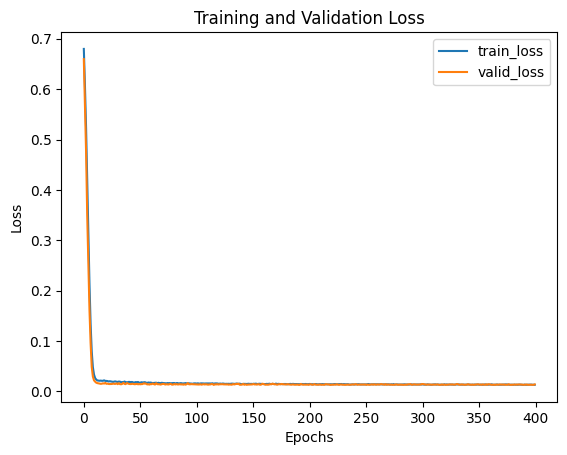

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 2 Train loss: 0.01290112230926752 Valid loss: 0.013628360600425648


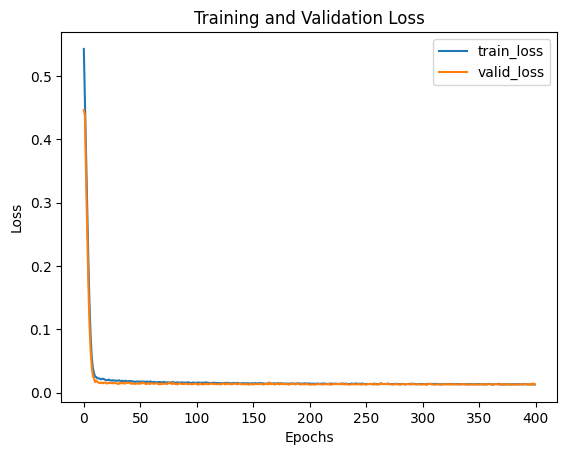

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 3 Train loss: 0.012776928618550301 Valid loss: 0.013341361513504615


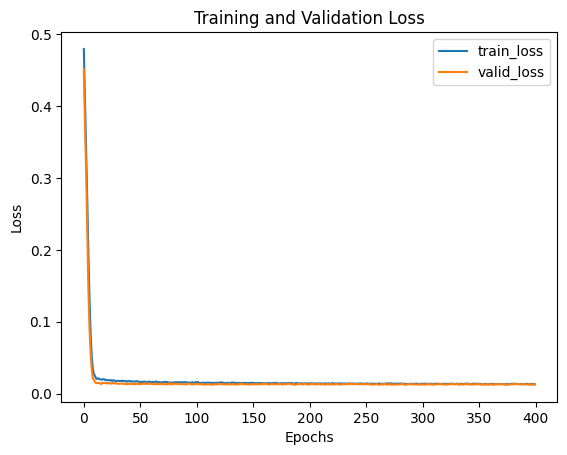

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 4 Train loss: 0.01418844671919942 Valid loss: 0.01508911820844962


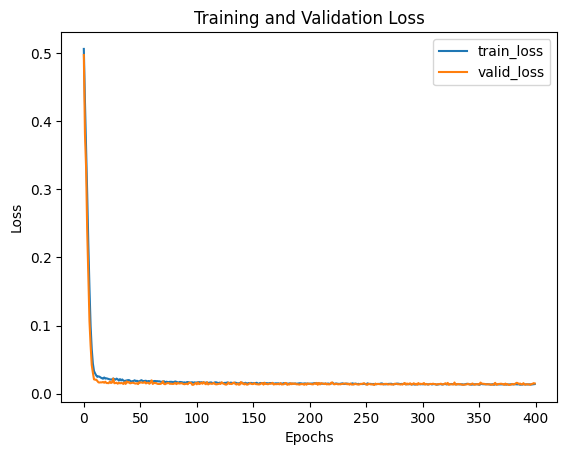

  0%|          | 0/400 [00:00<?, ?it/s]

KFold: 5 Train loss: 0.013346460573375225 Valid loss: 0.013226591480466036


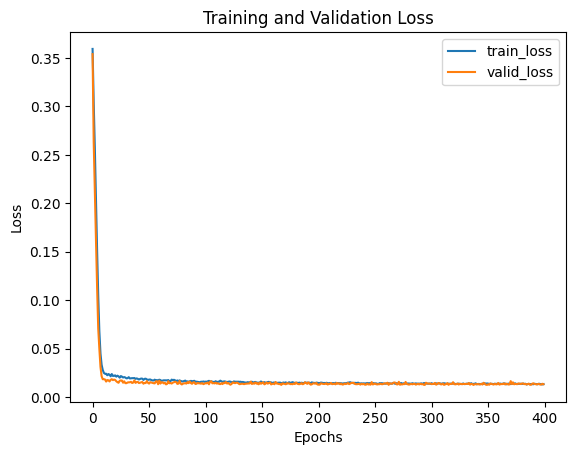

In [15]:
# Create an empty list to store the trained models
models = []

# Initialize KFold with K number of splits
kfold = KFold(n_splits=K)

# Loop over the K splits of the data
for fold_i, (train_idx, val_idx) in enumerate(kfold.split(train_data)):

    # Create the samplers for the training and validation sets
    train_sampler = SubsetRandomSampler(train_idx)
    valid_sampler = SubsetRandomSampler(val_idx)

    # Create the data loaders for the training and validation sets
    train_loader = DataLoader(
        train_data, batch_size=BATCH_SIZE, sampler=train_sampler)
    valid_loader = DataLoader(
        train_data, batch_size=BATCH_SIZE, sampler=valid_sampler)

    # Initialize the model using the hyperparameters of the best trial found by Optuna
    model = Model(**params)

    # Initialize the loss function based on the best trial found by Optuna
    loss_fn = getattr(nn, study.best_params['criterion'])(reduction='mean')

    # Initialize the optimizer using the hyperparameters of the best trial found by Optuna
    optimizer = getattr(optim, study.best_params['optimizer'])(model.parameters(
    ), lr=study.best_params['lr'], weight_decay=study.best_params['wd'])

    # Train the model for the specified number of epochs
    result = train(model, train_loader, valid_loader,
                   loss_fn, optimizer, EPOCHS, device)

    # Print the training and validation loss for the current fold
    print(
        f"KFold: {fold_i+1} Train loss: {result['train_loss'][-1]} Valid loss: {result['valid_loss'][-1]}")

    # Append the state dict of the trained model to the models list
    models.append(model.state_dict())

    # Plot the training and validation loss curves for the current fold
    plot(result, fold_i+1)


In [16]:
# Load the test data
test_data = pd.read_csv('data/test.csv')
# Convert the test data to a PyTorch tensor and move it to the device
test_x = torch.tensor(test_data.drop(
    ['id'], axis=1).values, dtype=torch.float32).view(-1, 2).to(device)

# Create an instance of the model with the best parameters
model = Model(**params).to(device)
# Initialize an array to hold the model outputs
outputs = np.zeros(len(test_x))

# Loop over the trained models and make predictions on the test data using each model
for model_i in models:
    # Load the state dict of the model
    model.load_state_dict(model_i)
    # Set the model to evaluation mode
    model.eval()

    # Make predictions on the test data using the current model
    outputs += model(test_x).cpu().detach().numpy().flatten()

# Divide the accumulated predictions by the number of models to get the average predictions
outputs /= len(models)

# Create a submission dataframe with the predicted values and save it to a CSV file
submission = pd.DataFrame({'id': range(1, len(outputs) + 1), 'y': outputs})
submission.to_csv('./submission.csv', index=False)


In [ ]:
# Load the submission file with the best predictions
best = pd.read_csv('my_submission.csv')
best = best['y'].values

# Calculate the mean squared error between the current model's predictions and the best predictions
mse = np.mean((outputs - best) ** 2)

# Print the mean squared error
print(mse)


In [18]:
# Model visualization
model = Model(**params)
summary(model, input_size=(6400, 2))


c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torchinfo\torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
c:\Users\River\anaconda3\envs\pytorch\lib\site-packages\torch\storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type:depth-idx)                   Output Shape              Param #
Model                                    [6400, 1]                 --
├─Sequential: 1-1                        [6400, 1]                 --
│    └─Linear: 2-1                       [6400, 16]                48
│    └─ReLU: 2-2                         [6400, 16]                --
│    └─BatchNorm1d: 2-3                  [6400, 16]                32
│    └─Linear: 2-4                       [6400, 32]                544
│    └─ReLU: 2-5                         [6400, 32]                --
│    └─BatchNorm1d: 2-6                  [6400, 32]                64
│    └─Linear: 2-7                       [6400, 64]                2,112
│    └─ReLU: 2-8                         [6400, 64]                --
│    └─BatchNorm1d: 2-9                  [6400, 64]                128
│    └─Linear: 2-10                      [6400, 128]               8,320
│    └─ReLU: 2-11                        [6400, 128]               --
│    └─